# Product Recommender System from Search Queries

Author: Timothy Leung

Updated: 19 October 2024

# Contents

- Overview
- Objectives
- Data
- Baseline Approach
    - Create a Fashion Anchor to Filter and Rank Searches
    - Find the Most Similar Product for Each Search
    - Limitations of Baseline Approach
- Proposed Solution
    - Create User-Product Interactions from Search Queries
    - Content-based Filtering
    - Collaborative Filtering
    - Hybrid Filtering
    - Further Improvements on Proposed Solution
- System Design
- References

# Overview

- New legal changes have strengthened data portability rights, requiring online search engines to allow users to export their search data.

- Users can choose to import their search data into a service that creates a distilled user profile, which can be shared with retailers to receive personalised recommendations.

- We propose a two-step approach:

    - transform user search queries into a demographic-guided user embedding profile; then

    - use this profile in a hybrid filtering system together with the product catalog to generate personalised recommendations.

# Objectives

- **Business Goal:** Increase retailer sales.

- **Machine Learning Goal:** Given a user's search history, select the items from a product catalogue that best match the customer's preferences.

# Data

In [3]:
%%capture
!pip install -U sentence-transformers

In [4]:
%%capture
import numpy as np
import pandas as pd
import torch

from google.colab import drive
from sentence_transformers import SentenceTransformer
from tqdm import tqdm

drive.mount('/content/drive')
model = SentenceTransformer('all-MiniLM-L6-v2')

FASHION_CATALOG = "/content/drive/MyDrive/fashion_challenge/fashion_catalog"
SEARCH_HISTORY = "/content/drive/MyDrive/fashion_challenge/search_history"

In [5]:
def batch_embed_texts(texts: list[str], batch_size: int = 32) -> np.ndarray:
    """
    Embeds a list of texts in batches and returns the combined embeddings.

    Args:
        texts: A list of text strings to embed.
        batch_size: The number of texts to process in each batch.

    Returns:
        A numpy array containing the embeddings for all input texts.
    """
    embeddings = []

    for i in tqdm(range(0, len(texts), batch_size), desc="Embedding batches"):
        batch_texts = texts[i:i+batch_size]
        batch_embeddings = model.encode(batch_texts, convert_to_numpy=True)
        embeddings.extend(batch_embeddings)
    return np.array(embeddings)

def extract_home_work(location_list: list[dict] | float) -> str | float:
    """
    Extracts the label 'Home' or 'Work' from a list of location data.

    Args:
        location_list: A list of location dictionaries, or NaN.

    Returns:
        'Home' if 'Home' is found in the 'source' field of the first dictionary,
        'Work' if 'Work' is found, or np.nan if neither is found or the input is
        invalid.
    """
    if pd.isna(location_list):
        return np.nan
    try:
        if isinstance(location_list, list) and len(location_list) > 0:
            source = location_list[0].get("source", "")
            if "Home" in source:
                return "Home"
            elif "Work" in source:
                return "Work"
    except (ValueError, SyntaxError):
        return np.nan
    return np.nan

The following preprocessing steps are applied to the search history data:

- Extract home/work to create location column.
- Drop rows with invalid URLs
- Ignore viewed/visited events and only keep searched events
- Drop duplicate searches
- Generate text embeddings from the `title` column

Search history features (concatenated):

- `time`: time at which website was accessed (integer)
- `location`: location where website was accessed, i.e. home or work (embedding)
- `text_embedding`: size 384 text embedding of the `title` column (embedding)

In [11]:
%%script true
df_search_history = pd.read_json(f"{SEARCH_HISTORY}.json", convert_dates=["time"])

# Extract home/work to create location column
df_search_history["location"] = df_search_history.locationInfos.apply(
    extract_home_work
).astype("category")

# Rename column
df_search_history.rename(columns={"titleUrl": "url"}, inplace=True)

# Drop rows with invalid URLs
df_search_history = df_search_history[~df_search_history.url.isna()]

# Drop extraneous columns
extraneous_columns = [
    "header",
    "products",
    "activityControls",
    "locationInfos",
    "subtitles",
    "details",
]
df_search_history.drop(columns=extraneous_columns, inplace=True)

# Ignore viewed/visited events
df_search_history = df_search_history[
    df_search_history.title.str.startswith("Searched for")
]
df_search_history["title"] = df_search_history.title.str[13:]

# Drop duplicate searches
df_search_history.drop_duplicates(subset=["title"], inplace=True)

# Sort titles by length for more efficient batch processiong
df_search_history.sort_values(by="title", key=lambda x: x.str.len(), inplace=True)

# Extract the titles as a list
titles = df_search_history["title"].tolist()

# Generate embeddings in batches
embeddings = batch_embed_texts(titles)

# Add text embeddings to the DataFrame
df_search_history["text_embedding"] = embeddings.tolist()

# Sort by time again
df_search_history.sort_values(by="time", inplace=True)

# Cache results
df_search_history.to_parquet(f"{SEARCH_HISTORY}.parquet")

The following preprocessing steps are applied to the product catalog data:

- The `category` and `gender` columns are converted into categorical data types
- Generate text embeddings from the `short_description` column

Product catalog features (concatenated):

- `gender`: M or F (embedding)
- `category`: product category, e.g. sneakers, tops, watches, etc. (embedding)
- `image_embedding`: aggregate image embedding of the `images` column (unimplemented)
- `text_embedding`: size 384 text embedding of the `short_description` column (embedding)

In [12]:
%%script true
df_product_catalog = pd.read_json(f"{FASHION_CATALOG}.json")

# Combine image columns
image_columns = ["MAIN_IMAGE", "SECOND_IMAGE", "THIRD_IMAGE", "FOURTH_IMAGE"]
df_product_catalog["IMAGES"] = df_product_catalog[image_columns].values.tolist()
df_product_catalog.drop(columns=image_columns, inplace=True)

# Set categorical columns
df_product_catalog.CATEGORY = df_product_catalog.CATEGORY.astype("category")
df_product_catalog.GENDER = df_product_catalog.GENDER.astype("category")

# Rename and downcase columns
df_product_catalog.rename({"LYST_PRODUCT_URL": "URL"}, inplace=True)
df_product_catalog.columns = map(str.lower, df_product_catalog.columns)

# Extract product name from Lyst product URL
df_product_catalog["product_name"] = df_product_catalog["lyst_product_url"].str.extract(r'/([^/]+)-\d+').str.replace('-', ' ')
df_product_catalog["product_name"] = df_product_catalog["product_name"].str.replace('-', ' ')

# Drop duplicate products
df_product_catalog.drop_duplicates(subset=["product_name"], inplace=True)

# Sort descriptions by length for more efficient batch processiong
df_product_catalog.sort_values(by="short_description", key=lambda x: x.str.len(), inplace=True)

# Extract the titles as a list
descriptions = df_product_catalog["short_description"].tolist()

# Generate embeddings in batches
embeddings = batch_embed_texts(descriptions)

# Add text embeddings to the DataFrame
df_product_catalog["text_embedding"] = embeddings.tolist()

# Cache results
df_product_catalog.to_parquet(f"{FASHION_CATALOG}.parquet")

Load cached data:

In [7]:
df_search_history = pd.read_parquet(f"{SEARCH_HISTORY}.parquet")
df_search_history

title  \
55380  investment banking networking events london   
55378          blackstone's women networking event   
55376                                   blackstone   
55374                                         face   
55372      how to find people's emails on data.com   
...                                            ...   
13                                      elevenlabs   
10                                           sunak   
6                              mukesh ambani house   
4                          bank station fire alert   
2                           elon musk shivon zilis   

                                                     url  \
55380  https://www.google.com/search?q=investment+ban...   
55378  https://www.google.com/search?q=blackstone%27s...   
55376         https://www.google.com/search?q=blackstone   
55374               https://www.google.com/search?q=face   
55372  https://www.google.com/search?q=how+to+find+pe...   
...                                                  ...   
13            https://www.google.com/search?q=elevenlabs   
10         https://www.google.com/search?q=sunak&tbm=nws   
6      https://www.google.com/search?q=mukesh+ambani+...   
4      https://www.google.com/search?q=bank+station+f...   
2      https://www.google.com/search?q=elon+musk+shiv...   

                                  time location  \
55380 2017-06-08 16:45:50.139000+00:00      NaN   
55378 2017-06-08 16:48:12.167000+00:00      NaN   
55376 2017-06-08 16:51:08.080000+00:00      NaN   
55374 2017-06-08 17:04:43.881000+00:00      NaN   
55372 2017-06-08 17:45:10.608000+00:00      NaN   
...                                ...      ...   
13    2024-06-21 21:55:34.004000+00:00     Home   
10    2024-06-22 07:38:19.979000+00:00     Home   
6     2024-06-22 20:40:58.305000+00:00     Home   
4     2024-06-23 16:52:09.311000+00:00     Home   
2     2024-06-23 22:20:47.560000+00:00     Home   

                                               embedding  
55380  [0.08599071949720383, -0.06804043799638748, -0...  
55378  [-0.007013967726379633, -0.006666566710919142,...  
55376  [-0.029014650732278824, 0.04590609669685364, -...  
55374  [-0.0771106407046318, 0.08789431303739548, -0....  
55372  [-0.03014201857149601, -0.02213406190276146, 0...  
...                                                  ...  
13     [-0.10916594415903091, -0.0017933961935341358,...  
10     [-0.025942513719201088, 0.11775815486907959, -...  
6      [0.011359811760485172, 0.11125904321670532, 0....  
4      [0.04344626143574715, 0.03764600306749344, -0....  
2      [-0.10273683816194534, 0.1268957257270813, -0....  

[25850 rows x 5 columns]

In [21]:
df_product_catalog = pd.read_parquet(f"{FASHION_CATALOG}.parquet")
df_product_catalog

lyst_product_url gender  category  \
82236  https://www.lyst.com/clothing/anna-molinari-to...      F      tops   
35190     https://www.lyst.com/clothing/hale-bob-top-290      F      tops   
91562  https://www.lyst.com/clothing/palm-angels-top-...      F      tops   
65830      https://www.lyst.com/clothing/relish-top-1415      F      tops   
91585  https://www.lyst.com/clothing/concepts-sport-r...      F      tops   
...                                                  ...    ...       ...   
52054  https://www.lyst.com/clothing/russell-ladies-s...      F      tops   
9735   https://www.lyst.com/accessories/tommy-hilfige...      F   watches   
36425  https://www.lyst.com/accessories/coach-2h-quar...      F   watches   
46626  https://www.lyst.com/shoes/puma-safety-touring...      F  sneakers   
58202  https://www.lyst.com/shoes/skechers-summits-sw...      F  sneakers   

                                       short_description  \
82236                                                Top   
35190                                                Top   
91562                                                Top   
65830                                                Top   
91585                                                Red   
...                                                  ...   
52054  Ladies Solid Flag Football Jersey – Premium Me...   
9735   Classic 3h Quartz Watch - Stainless Steel Wris...   
36425  2h Quartz Watch With Genuine Leather On A Chai...   
46626  Safety Touring White Low Work Shoe Safety Shoe...   
58202  Summits Swift Step ,ladies Trainers,skater,spo...   

                                        long_description  \
82236  Lace, gathered, two-tone, v-neck, sleeveless, ...   
35190  About the brand: Colorful femininity with a no...   
91562                 Top palm angels woman color black.   
65830  Satin, studs, solid color, deep neckline, slee...   
91585  Before the next Detroit Red Wings game day, be...   
...                                                  ...   
52054  FABRIC: Crafted from high-quality 100% nylon f...   
9735   Tommy Hilfiger Women's Watch - Classic 3H Quar...   
36425  Inspired by the sleek designs of 1920s Art Dec...   
46626                          Item no. 643450100000044.   
58202  Product type: Trainers,Slip-on,skater,sports s...   

                                                  images  \
82236  [https://cdna.lystit.com/photos/yoox/9ea9a61d/...   
35190  [https://cdna.lystit.com/photos/ruelala/c6ce9a...   
91562  [https://cdna.lystit.com/photos/giglio/cfda892...   
65830  [https://cdna.lystit.com/photos/yoox/fa0bbe56/...   
91585  [https://cdna.lystit.com/photos/macys/127d0ecc...   
...                                                  ...   
52054  [https://cdna.lystit.com/photos/amazon-prime/2...   
9735   [https://cdna.lystit.com/photos/amazon-prime/3...   
36425  [https://cdna.lystit.com/photos/amazon-prime/a...   
46626  [https://cdna.lystit.com/photos/amazon/e96d6a5...   
58202  [https://cdna.lystit.com/photos/amazon/4f29b30...   

                                               embedding  \
82236  [-0.05949341133236885, -0.005053779110312462, ...   
35190  [-0.05949341133236885, -0.005053779110312462, ...   
91562  [-0.05949341133236885, -0.005053779110312462, ...   
65830  [-0.05949341133236885, -0.005053779110312462, ...   
91585  [-0.02509157732129097, 0.00884629413485527, -0...   
...                                                  ...   
52054  [-0.024820750579237938, 0.06809557229280472, -...   
9735   [-0.07564269751310349, 0.07677403837442398, 0....   
36425  [-0.0790434256196022, 0.0965903028845787, 0.07...   
46626  [-0.04942594841122627, 0.010615060105919838, -...   
58202  [-0.05348265916109085, -0.037150800228118896, ...   

                                            product_name  
82236                                  anna molinari top  
35190                                       hale bob top  
91562                                    palm angels t

# Baseline Model

## Create a Fashion Anchor to Filter and Rank Searches

In [15]:
# Define the fashion anchor and generate its embedding
fashion_anchor = "fashion clothing apparel style"
anchor_embedding = model.encode(fashion_anchor, convert_to_tensor=True)

# Convert embeddings to tensors
search_embeddings = torch.tensor(np.stack(df_search_history["embedding"].values))

# Compute cosine similarities
cos = torch.nn.CosineSimilarity(dim=1)
similarities = cos(search_embeddings, anchor_embedding)

# Add similarity scores to the DataFrame
df_search_history["similarity_to_fashion"] = similarities.numpy()

# Rank searches by similarity
df_search_history = df_search_history.sort_values("similarity_to_fashion", ascending=False).reset_index(drop=True)

# Filter searches with a similarity threshold (e.g., >0.5)
threshold = 0.5
df_fashion_searches = df_search_history[df_search_history['similarity_to_fashion'] > threshold]

print("Fashion-related searches ranked by relevance:")
print(df_fashion_searches[['title', 'similarity_to_fashion']])


Fashion-related searches ranked by relevance:
                                 title  similarity_to_fashion
0              hiring designer clothes               0.678910
1            best clothes brands women               0.678380
2           Fashion accessories stores               0.665262
3                street fashion models               0.653721
4             best formal dress brands               0.649100
..                                 ...                    ...
75  most elegant office wear for women               0.504381
76                  london dress shops               0.503742
77     most stylish adidas women shoes               0.503573
78              calvin klein women bra               0.500862
79            london dress alterations               0.500207

[80 rows x 2 columns]


## Find the Most Similar Product for Each Search

In [24]:
# Convert embeddings to tensors for similarity computation
product_embeddings = torch.tensor(np.stack(df_product_catalog["embedding"].values))

# Using CosineSimilarity
cos = torch.nn.CosineSimilarity(dim=1)

# List to keep track of top 5 matches globally
global_top_matches = []

# Iterate over fashion-related searches
for idx, row in tqdm(df_fashion_searches.iterrows(), total=df_fashion_searches.shape[0]):
    search_embeddings = torch.tensor(row["embedding"])

    # Compute cosine similarities
    similarities = cos(product_embeddings, search_embeddings)

    # Get top 5 similar products for the current search
    top_results = torch.topk(similarities, k=5)
    top_indices = top_results.indices.numpy()
    top_scores = top_results.values.numpy()

    # Add the current top 5 results to the global list with search context
    for prod_idx, sim_score in zip(top_indices, top_scores):
        product = df_product_catalog.iloc[prod_idx]
        global_top_matches.append({
            'search_title': row['title'],
            'product_description': (product['short_description'] + ' ' +
                                    product['long_description']),
            'score': row['similarity_to_fashion'] * sim_score
        })

# Sort the global list by similarity score in descending order
global_top_matches = sorted(global_top_matches, key=lambda x: x['score'], reverse=True)

# Get the top 5 overall best matches
top_5_overall_matches = global_top_matches[:5]

# Display the results
print("\nOverall Top 5 Matches:")
for match in top_5_overall_matches:
    print(f"Search: {match['search_title']}")
    print(f"Product: {match['product_description']} (Score: {match['score']:.4f})\n")


Overall Top 5 Matches:
Search: long sleeve dress
Product: Long Sleeve Dress 55% mohair 29% polyamide 16% wool. Made in China. Hand wash. Unlined. Pull-on styling. Chunky knit fabric. (Score: 0.5567)

Search: long sleeve dress
Product: Long Sleeve Dress Long Sleeve Dress from Federica TosiComposition: 68% Silk, 32% Acetato (Score: 0.5567)

Search: designer dresses for women
Product: Women's Dresses Dress realized in linen and cotton characterized by adjustable contrasting leather shoulder straps. V neckline- Backless- Concealed buttons closure- Lateral slits at the back - Flared hemline- Unlined. (Score: 0.5451)

Search: eyewear
Product: Eyewear Eyewear from LapimaFrame composition: AcetatePolarized: noCrystal lenses: no (Score: 0.5397)

Search: eyewear
Product: Eyewear Eyewear from Robert La RocheFrame composition: AcetatePolarized: noCrystal lenses: no (Score: 0.5397)



## Limitations of Baseline Approach

- Dependent on various hyperparameters:
    - assumes that `fashion clothing apparel style` is a suitable anchor
    - assumes that a similarity threshold of `0.5` is a good cut-off
    - assumes that a global ranking can be effectively determined by a linear relationship between the similarity-to-fashion score and the cosine similarity between the search term and product catalog item
- Lack of overall user style profile
- No consideration of product popularity or trends across time and location
- Computationally expensive to calculate text embeddings for each individual search query for every user

# Proposed Solution

## Create User-Product Interactions from Search Queries

- Below, we use exact matching to match search queries with products in the catalog. However, this method only works well for brand names and struggles with matching exact products.

- In reality, we would use a more robust solution such as Named Entity Recognition (NER) to match search queries with the product catalog.

- Text embeddings could also improve accuracy, but we need to be mindful of the computational costs. Given that the user submits nearly 4,000 queries per year, a high-cost model for each query might not be feasible at scale.

In [50]:
df_interactions = df_search_history.merge(df_product_catalog, left_on='title', right_on='product_name')
df_interactions.head()

title                                                url  \
0         anine bing         https://www.google.com/search?q=anine+bing   
1            bershka            https://www.google.com/search?q=bershka   
2                gap                https://www.google.com/search?q=gap   
3  alexander mcqueen  https://www.google.com/search?q=alexander+mcqueen   
4          hugo boss          https://www.google.com/search?q=hugo+boss   

                              time location  \
0 2018-05-09 15:49:30.590000+00:00      NaN   
1 2018-06-18 12:23:56.461000+00:00      NaN   
2 2018-07-02 13:41:13.971000+00:00      NaN   
3 2018-08-18 18:22:34.753000+00:00      NaN   
4 2018-09-02 11:43:55.726000+00:00      NaN   

                                    text_embedding_x  \
0  [-0.019811075180768967, -0.07993888109922409, ...   
1  [-0.0002757411275524646, 0.08584881573915482, ...   
2  [-0.029173998162150383, 0.07321958243846893, -...   
3  [-0.05550515651702881, 0.0639433041214943, -0....   
4  [-0.1051834300160408, 0.03165801241993904, 0.0...   

                                    lyst_product_url gender   category  \
0  https://www.lyst.com/shoes/anine-bing-40mm-rae...      F      boots   
1  https://www.lyst.com/jewelry/bershka-2-pack-of...      F   earrings   
2  https://www.lyst.com/clothing/gap-3-pk-cotton-...      M   t-shirts   
3  https://www.lyst.com/shoes/alexander-mcqueen-7...      F      boots   
4  https://www.lyst.com/clothing/hugo-boss-3p-rs-...      M  underwear   

                      short_description  \
0  40mm Rae Croc Embossed Leather Boots   
1              2-Pack Of Chain Earrings   
2         3-pk. Cotton Ribbed Tank Tops   
3              70Mm Leather Ankle Boots   
4  Boss 3p Rs Rib Logo Cc Regular Socks   

                                    long_description  \
0  40mm Heel. Leather upper. All over embossed pa...   
1  2-pack of chain earrings - Signature Edition C...   
2  A three-pack of ribbed cotton tank tops from G...   
3  Black leather metal toecap pointed toe ankle-l...   
4            77% Cotton, 20% Polyamide, 3% Elastane.   

                                              images  \
0  [https://cdna.lystit.com/photos/lvr/41e0222b/a...   
1  [https://cdna.lystit.com/photos/bershka/ae4904...   
2  [https://cdna.lystit.com/photos/macys/3d6d5fb4...   
3  [https://cdna.lystit.com/photos/farfetch/41660...   
4  [https://cdna.lystit.com/photos/amazon/66e462d...   

                                    text_embedding_y       product_name  
0  [-0.04883867874741554, 0.047819457948207855, -...         anine bing  
1  [0.03614421561360359, 0.026941049844026566, 0....            bershka  
2  [-0.011505736038088799, 0.04154190793633461, -...                gap  
3  [-0.08726326376199722, 0.0819750726222992, 0.0...  alexander mcqueen  
4  [-0.06182621419429779, 0.027048243209719658, -...          hugo boss

## Content-based Filtering

- Content-based filtering uses item features to recommend similar items

- We filter by `gender` and `category` and then compute similarities using `text_embedding`

In [49]:
# Using CosineSimilarity
cos = torch.nn.CosineSimilarity(dim=1)

# List to keep track of top 5 matches globally
global_top_matches = []

# Iterate over fashion-related searches
for idx, row in tqdm(df_interactions.iterrows(), total=df_interactions.shape[0]):
    # Create a temp dataframe for products matching the search query's gender and category
    filtered_products = df_product_catalog[
        (df_product_catalog['gender'] == row['gender']) &
        (df_product_catalog['category'] == row['category'])
    ]

    # If no matching products, skip the iteration
    if filtered_products.empty:
        continue

    # Convert filtered product embeddings to tensor
    filtered_product_embeddings = torch.tensor(np.stack(filtered_products["text_embedding"].values))

    # Get the search embedding for the current query
    search_embedding = torch.tensor(row["text_embedding_y"])

    # Compute cosine similarities
    similarities = cos(filtered_product_embeddings, search_embedding)

    # Get top 2 similar products (to remove the top one which is the query product itself)
    top_results = torch.topk(similarities, k=2)
    top_indices = top_results.indices[1:].numpy()
    top_scores = top_results.values[1:].numpy()

    # Add the result to the global list with search context
    for prod_idx, sim_score in zip(top_indices, top_scores):
        product = df_product_catalog.iloc[prod_idx]
        global_top_matches.append({
            'search_title': row['title'],
            'product_description': (product['product_name'] + ' ' +
                                    product['short_description'] + ' ' +
                                    product['long_description']),
            'score': sim_score
        })

# Sort the global list by similarity score in descending order
global_top_matches = sorted(global_top_matches, key=lambda x: x['score'], reverse=True)

# Get the top 5 overall best matches
top_5_overall_matches = global_top_matches[:5]

# Display the results
print("\nOverall Top 5 Matches:")
for match in top_5_overall_matches:
    print(f"Search: {match['search_title']}")
    print(f"Product: {match['product_description']} (Score: {match['score']:.4f})\n")

100%|██████████| 41/41 [00:00<00:00, 88.90it/s]


Overall Top 5 Matches:
Search: burberry scarf
Product: hale bob top Top About the brand: Colorful femininity with a nod to Boho style. (Score: 1.0000)

Search: gucci belt
Product: palm angels top Top Top palm angels woman color black. (Score: 1.0000)

Search: adidas
Product: liviana conti top Top Knitted, medium-weight knit, no appliqués, solid colour, deep neckline, sleeveless, 1 button, no pockets. 100% Cotton. (Score: 1.0000)

Search: dkny bags
Product: parosh blouse Top Plain weave, embroidered detailing, two-tone, bow collar, long sleeves, buttoned cuffs, no pockets. 100% Cotton. (Score: 1.0000)

Search: max mara coats
Product: rrd top polyamide elastane Top Top, jersey, no appliqués, geometric-print, halterneck, sleeveless, without pockets, stretch, machine wash, do not bleach, do not tumble dry. 86% Polyamide, 14% Elastane. (Score: 1.0000)



## Collaborative Filtering

- Collaborative filtering uses user-item interaction data to recommend complementary items.

- Can be faced with the cold-start problem, where there is insufficient user-item interaction data to generate recommendations effectively.

- Instead of relying solely on user embeddings, we can supplement them with additional features derived from user demographics.

    - These features can be learned by training classifiers on ground truth data, such as survey responses from a subset of users.
    
    - Alternatively, we can attempt a zero-shot approach, inferring demographic features directly from the user's search queries.


- <mark>We haven't implemented this here because we have only been provided data for a single user.</mark>

## Hybrid Filtering

Hybrid filtering combines both content-based filtering and collaborative filtering. By using both user interaction data and item features, hybrid models help users discover new content while also suggesting items similar to what they have previously interacted with.

## Further Improvements on Proposed Solution

- **Collect additional data**: Incorporate purchase data to capture stronger intent signals. Collect demographic data for a subset of users to supplement user embeddings.

- **Use Named Entity Recognition for creating user-item interactions**: Use NER to extract key entities from search queries, allowing for more accurate matching to products without relying on exact string matches.

- **Predict entire outfits**: Use knowledge graphs, co-purchase data, and social media images to recommend complete outfits.

- **Enable context-aware querying**: Factor in device, location, and time to refine the relevance of recommendations.

- **Add interpretability**: Provide clear explanations for why specific items are recommended.

# Evaluation

### Offline Metrics

If ground truth data is available, such as relevant products identified through historical behavior or expert labels, it can be used to evaluate the system. These include:

- **Precision@K:** Measures the proportion of relevant items among the top K recommended.
- **Recall@K:** Evaluates how many relevant items are successfully retrieved in the top K.
- **Mean Average Precision (MAP):** Averages precision scores across multiple queries, focusing on how well relevant items are ranked.
- **Mean Reciprocal Rank (MRR):** Assesses the rank of the first relevant item, rewarding systems that present relevant results earlier.

### Online Metrics

If user feedback from direct interaction with the system is available, implicit feedback can be used to evaluate the system. This can be achieved by tracking customer engagement through metrics such as:

- **Click-Through Rate (CTR):** The percentage of recommended products that are clicked by users.
- **Conversion Rate:** The proportion of clicks that result in desired actions, such as purchases.
- **Time Spent:** Measures how much time users spend interacting with recommended products, reflecting product relevance and engagement.

# System Design

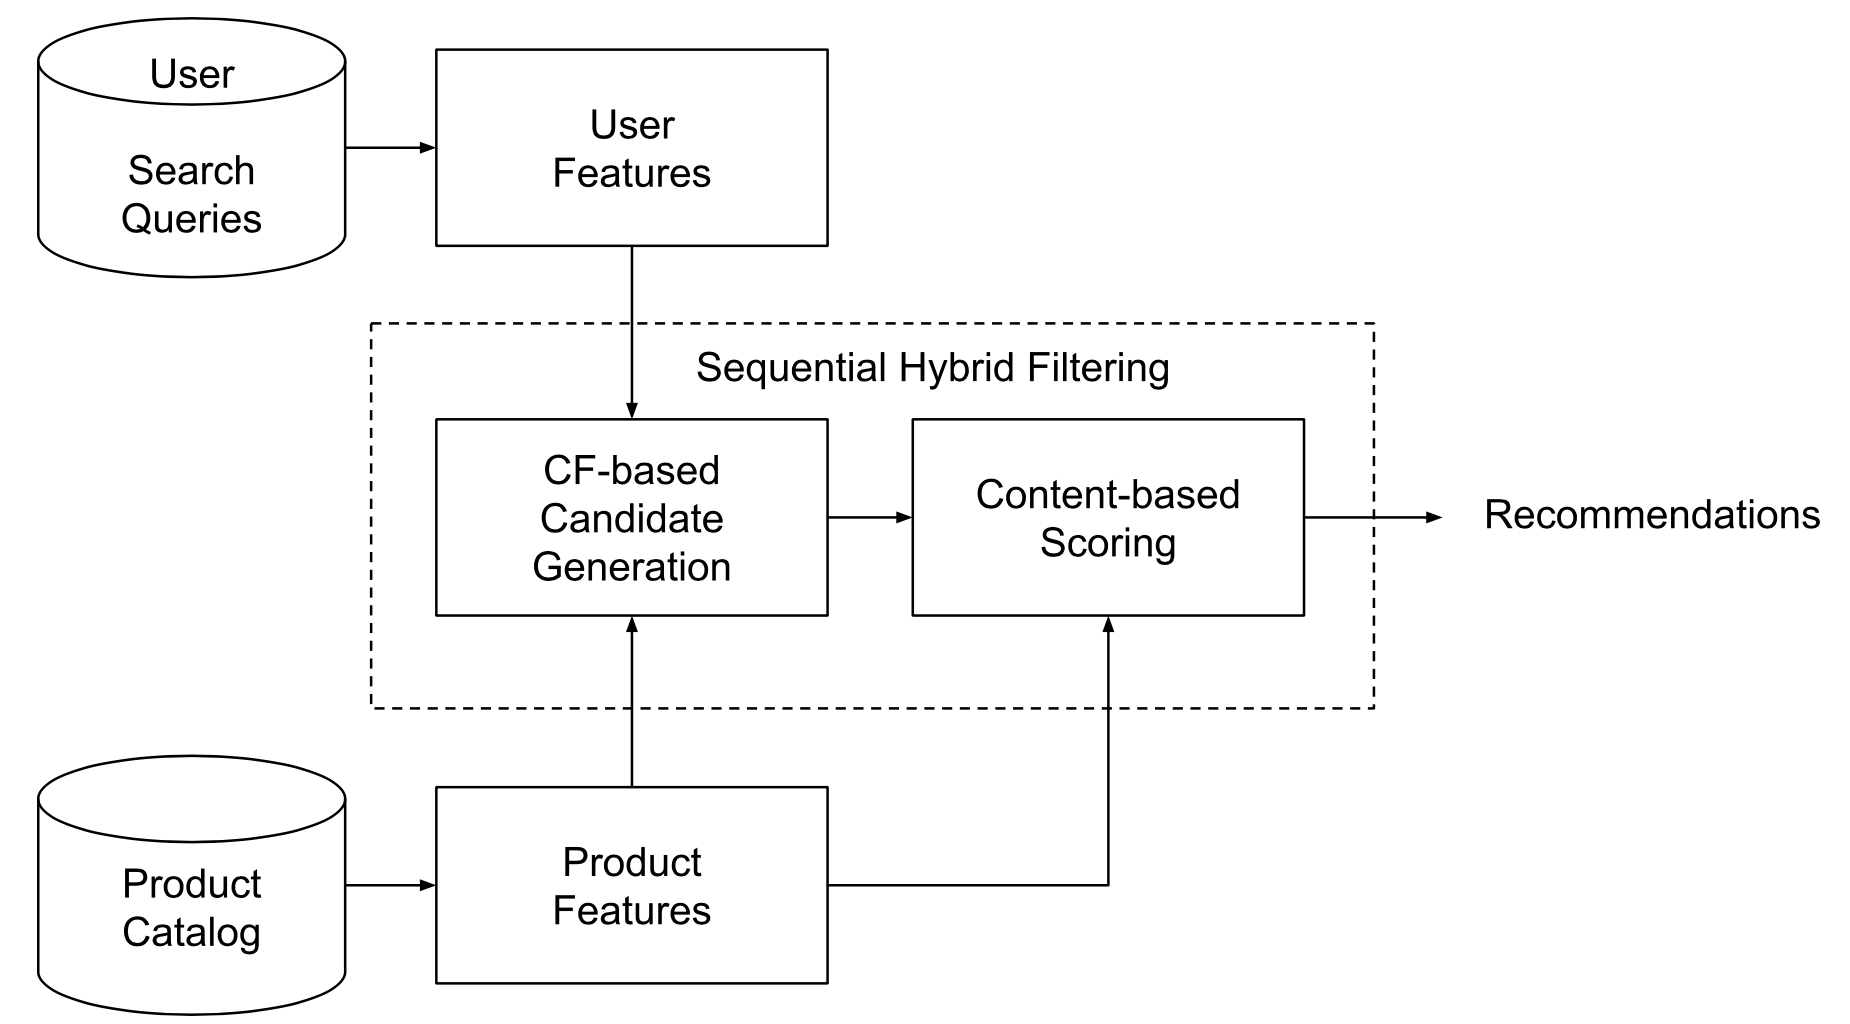


To balance serving speed and recommendation quality, we use a sequential hybrid filtering approach:

- **Collaborative Filtering-based Candidate Generation**: We start with a lightweight CF-based model to quickly generate candidates. This approach is efficient as it relies on pre-trained embeddings and doesn’t require retraining at serve time, though it may not provide the best quality recommendations alone.

- **Content-Based Scoring**: Next, we apply a more intensive content-based model to score and rank the candidates using multiple embeddings (e.g., gender, category, text). While more expensive, this step prioritises accuracy over speed to ensure high-quality recommendations.

- **Re-ranking**: Finally, we re-rank recommendations to account for factors like seasonality, product diversity, and removing duplicates, ensuring a diverse and relevant final list of recommendations.

# References

- [A Review of Modern Fashion Recommender Systems (Polytechnic University of Bari)](https://arxiv.org/abs/2202.02757)
- [Algorithm-Assisted Inventory Curation (Stitchfix)](https://multithreaded.stitchfix.com/blog/2021/05/12/algorithm-assisted-inventory-curation/)
- [Complete the Look: Scene-based Complementary Product Recommendation (Pinterest)](https://arxiv.org/abs/1812.01748)
- [H&M Personalized Fashion Recommendations (Kaggle)](https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations/overview)
- [Rethinking Personalized Ranking at Pinterest: An End-to-End Approach (Pinterest)](https://arxiv.org/abs/2209.08435)